In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
import re
import pandas as pd
import copy
import numpy as np
from pathlib import Path
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch
import torch.nn as nn

import time
from datetime import datetime

# Add the project root to the path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.utils import extract_trailing_numbers, set_seed
import flowmol

In [ ]:
cwd = os.path.join(os.getcwd(), '../')

In [5]:
qm9_stats = pd.read_csv(cwd + 'data/QM9/raw/gdb9.sdf.csv').set_index('mol_id')
qm9_stats.describe()

,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
count,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000
mean,9.814382,1.406097,1.124921,2.706037,75.191296,-0.239977,0.011124,0.251100,1189.527450,0.148524,-411.543985,-411.535513,-411.534569,-411.577397,31.600676,-1750.812997,-1761.480647,-1771.546928,-1629.388196
std,1809.465666,1.583795,1.095618,1.530394,8.187793,0.022131,0.046936,0.047519,279.757172,0.033274,40.060230,40.060012,40.060012,40.060741,4.062471,239.313373,241.436103,243.151065,220.207088
min,0.000000,0.337120,0.331180,0.000000,6.310000,-0.428600,-0.175000,0.024600,19.000200,0.015951,-714.568061,-714.560153,-714.559209,-714.602138,6.002000,-2608.448864,-2626.408172,-2643.007040,-2417.121997
25%,2.554430,1.091630,0.910480,1.588700,70.380000,-0.252500,-0.023800,0.216300,1018.322600,0.125289,-437.913936,-437.905942,-437.904997,-437.947682,28.942000,-1904.772194,-1916.981009,-1928.181417,-1771.350603
50%,3.090360,1.369940,1.078560,2.500000,75.500000,-0.241000,0.012000,0.249400,1147.585800,0.148329,-417.864758,-417.857351,-417.856407,-417.895731,31.555000,-1753.464714,-1764.090324,-1774.151176,-1632.224955
75%,3.835820,1.653980,1.279540,3.636100,80.520000,-0.228700,0.049200,0.288200,1308.816600,0.171150,-387.049166,-387.039746,-387.038802,-387.083279,34.276000,-1596.871098,-1606.108658,-1615.066349,-1488.291333
max,619867.683140,437.903860,282.945450,29.556400,196.620000,-0.101700,0.193500,0.622100,3374.753200,0.273944,-40.478930,-40.476062,-40.475117,-40.498597,46.969000,-213.087624,-213.974294,-215.159658,-201.407171


In [6]:
qm9_stats.head()

,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
mol_id,,,,,,,,,,,,,,,,,,,
gdb_1,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
gdb_2,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
gdb_3,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
gdb_4,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
gdb_5,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028


In [7]:
qm9_stats.columns

Index(['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0',
       'u298', 'h298', 'g298', 'cv', 'u0_atom', 'u298_atom', 'h298_atom',
       'g298_atom'],
      dtype='object')

In [8]:
qm9_stats['mu'].describe()


count    133885.000000
mean          2.706037
std           1.530394
min           0.000000
25%           1.588700
50%           2.500000
75%           3.636100
max          29.556400
Name: mu, dtype: float64

In [9]:
qm9_stats['u0'].describe()

count    133885.000000
mean       -411.543985
std          40.060230
min        -714.568061
25%        -437.913936
50%        -417.864758
75%        -387.049166
max         -40.478930
Name: u0, dtype: float64

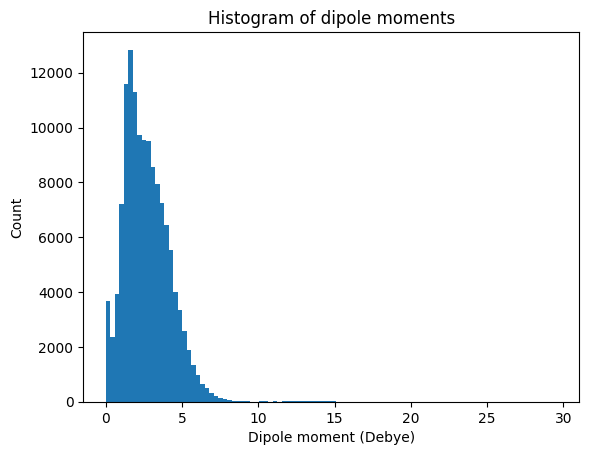

In [10]:
# Histogram of dipole moments
plt.hist(qm9_stats['mu'], bins=100)
plt.xlabel('Dipole moment (Debye)')
plt.ylabel('Count')
plt.title('Histogram of dipole moments')
plt.show()

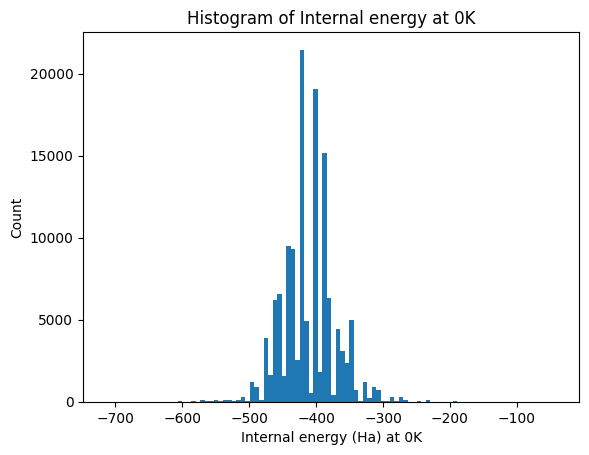

In [20]:
# Histogram of Internal energy at 0 K
plt.hist(qm9_stats['u0'], bins=100)
plt.xlabel('Internal energy (Ha) at 0K')
plt.ylabel('Count')
plt.title('Histogram of Internal energy at 0K')
plt.show()

In [44]:
df_scores = pd.read_csv(cwd + 'data/QM9/raw/gdb9_sascore.sdf.csv').set_index('mol_id')['sa_score']
df_scores.describe()

count    133885.000000
mean          7.408026
std           0.962875
min           1.000000
25%           6.977632
50%           7.547612
75%           7.927623
max          11.000000
Name: sa_score, dtype: float64

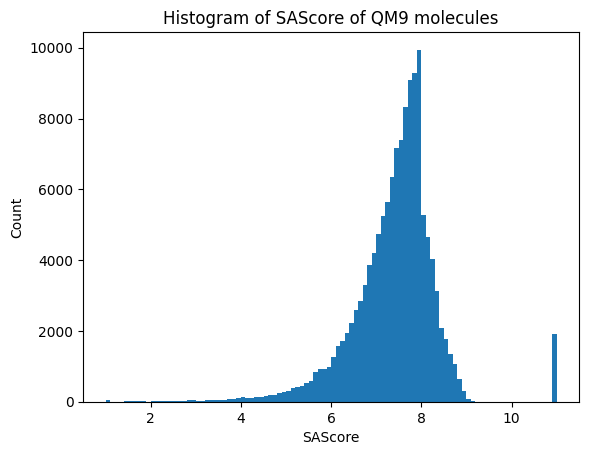

In [45]:
# Histogram of SAScore
plt.hist(df_scores, bins=100)
plt.xlabel('SAScore')
plt.ylabel('Count')
plt.title('Histogram of SAScore of QM9 molecules')
plt.show()

In [46]:
import os, glob, pandas as pd

def parse_qm9_xyz(fp: str) -> dict:
    """Return one record with name, n_atoms, smiles and atom list."""
    with open(fp) as f:
        # strip blank lines that occasionally appear in some dumps
        lines = [ln.strip() for ln in f if ln.strip()]
    n_atoms        = int(lines[0])
    props          = lines[1].split()
    name           = f'gdb_{props[1]}'          #  gdb1, gdb25, …
    atom_section   = lines[2:2+n_atoms]
    atoms          = [ln.split()[0] for ln in atom_section]
    smiles1         = lines[-2].split('\t')[0]          # first SMILES token
    smiles2         = lines[-2].split('\t')[1]          # second SMILES token

    return {"name": name, "n_atoms": n_atoms, "smiles": smiles1, "long_smiles": smiles2, "atoms": atoms}

folder = cwd + 'data/QM9/xyz/'
records = [parse_qm9_xyz(fp) for fp in glob.glob(os.path.join(folder, "*.xyz"))]

df = pd.DataFrame(records).set_index("name")
df['sort_key'] = df.index.str.extract(r'gdb_(\d+)', expand=False).astype(int)
df = df.sort_values('sort_key').drop(columns='sort_key')
df.head()

,n_atoms,smiles,long_smiles,atoms
name,,,,
gdb_1,5,C,C,"[C, H, H, H, H]"
gdb_2,4,N,N,"[N, H, H, H]"
gdb_3,3,O,O,"[O, H, H]"
gdb_4,4,C#C,C#C,"[C, C, H, H]"
gdb_5,3,C#N,C#N,"[C, N, H]"


In [ ]:
df_scores = df_scores.to_frame(name='sa_score')
df = df.join(df_scores)
df.head()

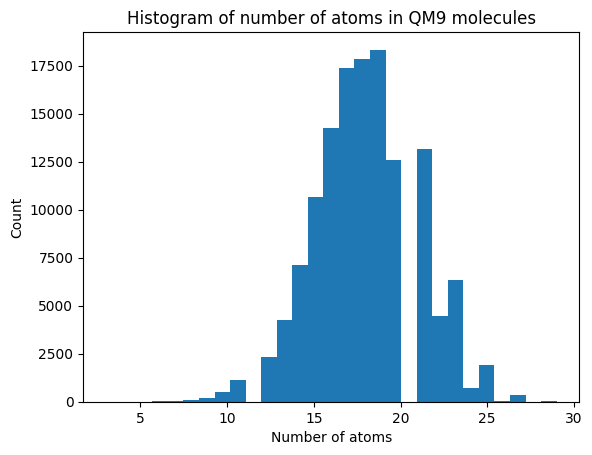

In [49]:
# Histogram of SAScore
plt.hist(df['n_atoms'], bins=29)
plt.xlabel('Number of atoms')
plt.ylabel('Count')
plt.title('Histogram of number of atoms in QM9 molecules')
plt.show()

In [50]:
summary = df.groupby('n_atoms')['sa_score'].describe()
print(summary[['mean', 'std', 'min', 'max']])


             mean       std       min        max
n_atoms                                         
3        7.071920  0.614913  6.637111   7.506730
4        5.643438  2.201987  3.599964   7.815973
5        5.530129  2.411485  2.088791   7.902070
6        5.762992  1.589108  2.869776   7.931855
7        5.776954  1.030453  3.988085   7.979988
8        5.648031  1.196752  2.028732   7.875246
9        5.592737  1.046073  2.992636   7.945552
10       5.870486  0.968434  1.000000  11.000000
11       6.211919  1.002493  4.207469  11.000000
12       6.523037  0.976551  3.775299  11.000000
13       6.818776  0.935187  1.000000  11.000000
14       7.021991  0.926516  1.000000  11.000000
15       7.183442  0.931831  1.000000  11.000000
16       7.311608  0.936813  1.000000  11.000000
17       7.382973  0.978805  1.000000  11.000000
18       7.459924  0.933005  1.000000  11.000000
19       7.532867  0.951502  1.000000  11.000000
20       7.610833  0.910172  1.000000  11.000000
21       7.711749  0

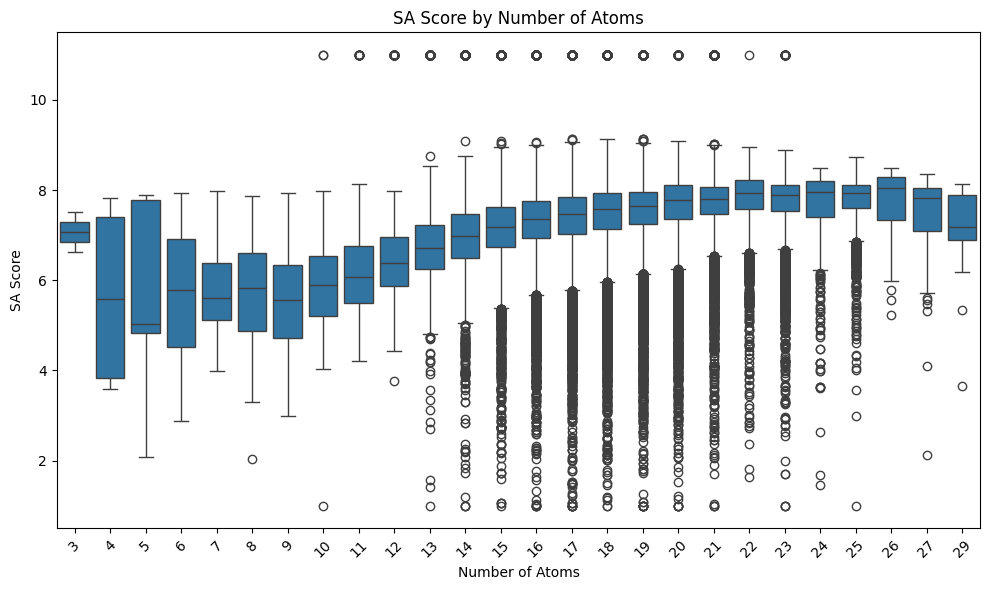

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group and plot sa_score distribution by n_atoms
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='n_atoms', y='sa_score')

plt.title('SA Score by Number of Atoms')
plt.xlabel('Number of Atoms')
plt.ylabel('SA Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: xlabel='n_atoms', ylabel='sa_score'>

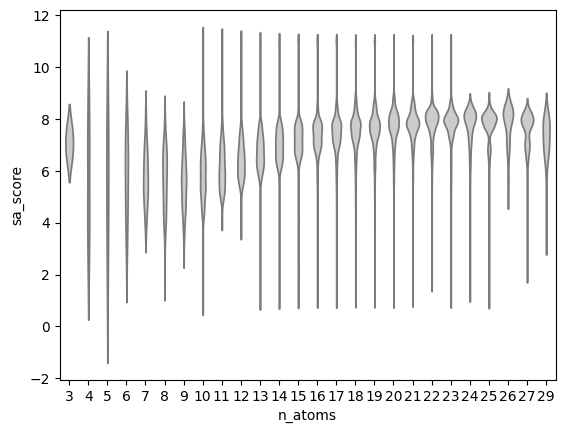

In [53]:
sns.violinplot(data=df, x='n_atoms', y='sa_score', inner=None, color=".8")

<Axes: xlabel='n_atoms', ylabel='sa_score'>

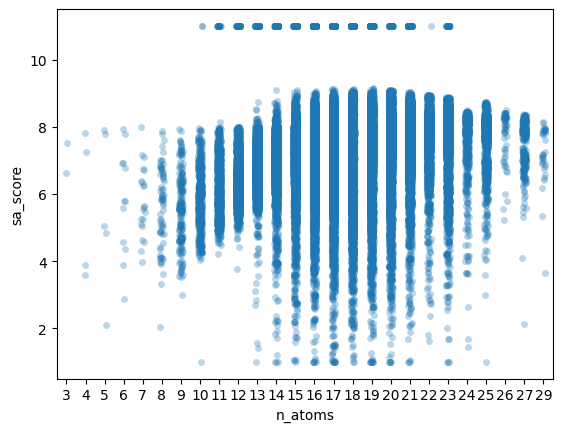

In [54]:
sns.stripplot(data=df, x='n_atoms', y='sa_score', jitter=True, alpha=0.3)

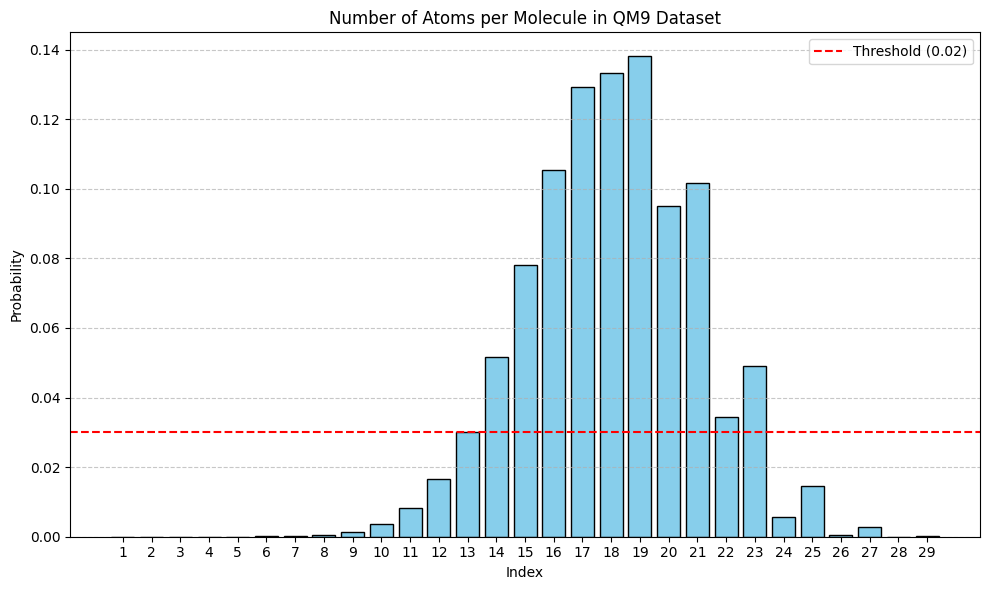

In [ ]:
# Plot histogram of:
probs = [0,0,1.0381e-05, 3.1142e-05, 3.1142e-05, 9.3425e-05, 1.6609e-04, 5.1903e-04,
        1.3702e-03, 3.6955e-03, 8.1384e-03, 1.6474e-02, 3.0072e-02, 5.1726e-02,
        7.8145e-02, 1.0528e-01, 1.2912e-01, 1.3318e-01, 1.3806e-01, 9.5024e-02,
        1.0156e-01, 3.4495e-02, 4.9204e-02, 5.5847e-03, 1.4502e-02, 4.3598e-04,
        2.8027e-03, 0, 2.6989e-04]
# with index 3 to 27 and 29
x_ticks = list(range(1, 30))
plt.figure(figsize=(10, 6))
plt.bar(x_ticks, probs, width=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.title('Number of Atoms per Molecule in QM9 Dataset')
plt.xticks(x_ticks)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=0.03, color='r', linestyle='--', label='Threshold (0.03)')
plt.legend()
plt.tight_layout()
plt.show()

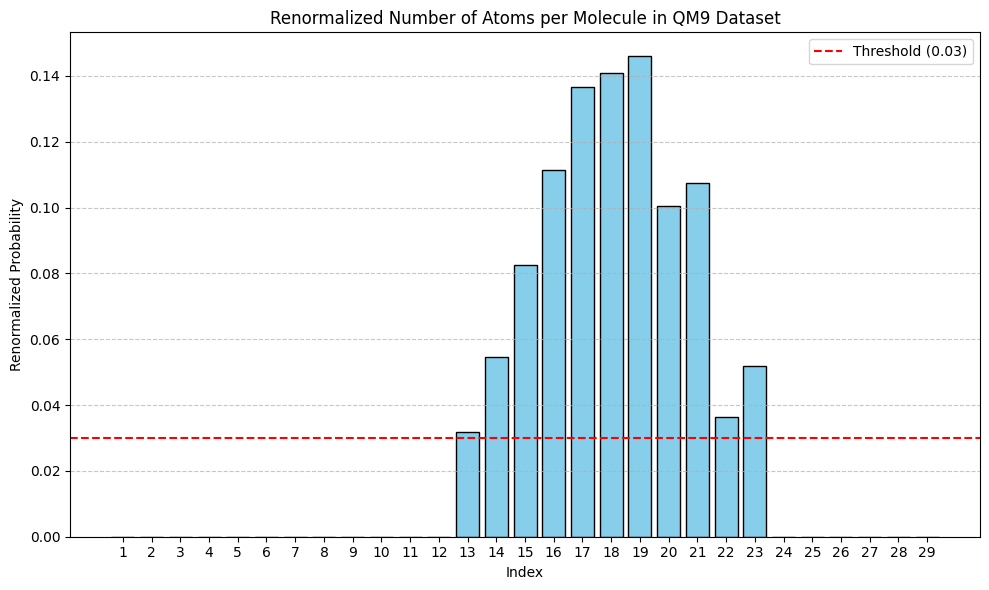

In [20]:
# renormalize probs but just with probs>0.02
re_probs = np.array(probs)
re_probs[re_probs < 0.03] = 0
re_probs /= re_probs.sum()
# Plot histogram of renormalized probs
plt.figure(figsize=(10, 6))
plt.bar(x_ticks, re_probs, width=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Index')
plt.ylabel('Renormalized Probability')
plt.title('Renormalized Number of Atoms per Molecule in QM9 Dataset')
plt.xticks(x_ticks)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=0.03, color='r', linestyle='--', label='Threshold (0.03)')
plt.legend()
plt.tight_layout()
plt.show()


### Energy - Dipole - Forces w/ dxtb

In [ ]:
def parse_sampling_log(filepath):
    with open(filepath, 'r') as file:
        content = file.read()

    entries = content.split('--- Start ---')
    data = []

    for entry in entries:
        if not entry.strip():
            continue

        # Extract property and number of atoms
        property_match = re.search(r'Property:\s*(\w+)', entry)
        atoms_match = re.search(r'Sampling molecules with (\d+) atoms', entry)
        stats_match = re.search(
            r'mean_of_means: ([\d\.\-e]+)\s+'
            r'std_of_means_of_means: ([\d\.\-e]+)\s+'
            r'median_of_means: ([\d\.\-e]+)\s+'
            r'mean_of_medians: ([\d\.\-e]+)\s+'
            r'std_of_medians_of_means: ([\d\.\-e]+)\s+'
            r'median_of_medians: ([\d\.\-e]+)', entry)

        if not (property_match and atoms_match and stats_match):
            continue

        property_name = property_match.group(1)
        num_atoms = int(atoms_match.group(1))
        stats = [float(g) for g in stats_match.groups()]

        data.append({
            'property': property_name,
            'num_atoms': num_atoms,
            'mean_of_means': stats[0],
            'std_of_means_of_means': stats[1],
            'median_of_means': stats[2],
            'mean_of_medians': stats[3],
            'std_of_medians_of_means': stats[4],
            'median_of_medians': stats[5],
        })

    return pd.DataFrame(data)

def plot_stats(df, dataset, save=False):
    props = df['property'].unique()
    for prop in props:
        subset = df[df['property'] == prop].sort_values('num_atoms')
        
        plt.figure()
        # x axis: num_atoms should be sorted and integer ticks
        plt.plot(subset['num_atoms'], subset['mean_of_means'], marker='o', label='Mean of Means')
        plt.plot(subset['num_atoms'], subset['median_of_means'], marker='s', label='Median of Means')
        # plt.plot(subset['num_atoms'], subset['mean_of_medians'], marker='^', label='Mean of Medians')
        plt.title(f'Atom Count vs {prop}')
        plt.xlabel('Number of Atoms')
        plt.ylabel(f'{prop}')
        plt.legend()
        plt.grid(True)
        ax = plt.gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune=None, nbins=15))

        plt.tight_layout()
        if save:
            plt.savefig(f'/Users/svlg/MasterThesis/v02/aa_experiments/sampling/{dataset}/{prop}_per_number_of_atoms_properties.png')
        else:
            plt.show()


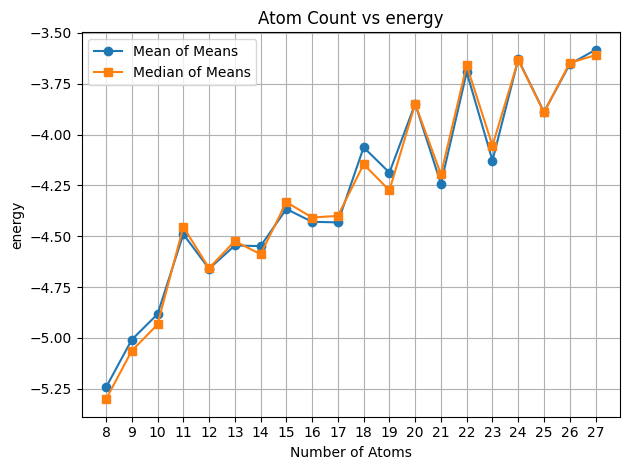

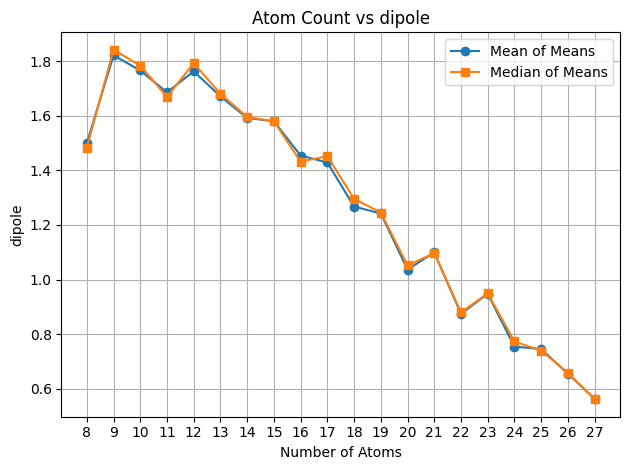

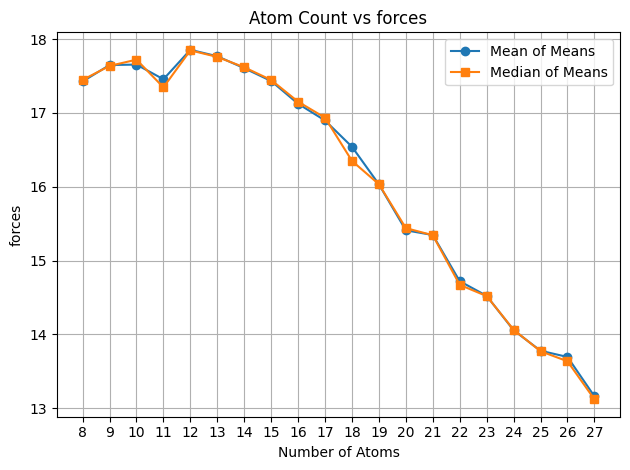

In [7]:
# MAIN EXECUTION
txt_file = '/Users/svlg/MasterThesis/v02/aa_experiments/sampling/qm9/per_number_of_atoms_properties_long.txt'
df = parse_sampling_log(txt_file)
df.to_csv('/Users/svlg/MasterThesis/v02/aa_experiments/sampling/qm9/sampling_summary.csv', index=False)
plot_stats(df, dataset='qm9', save=True)

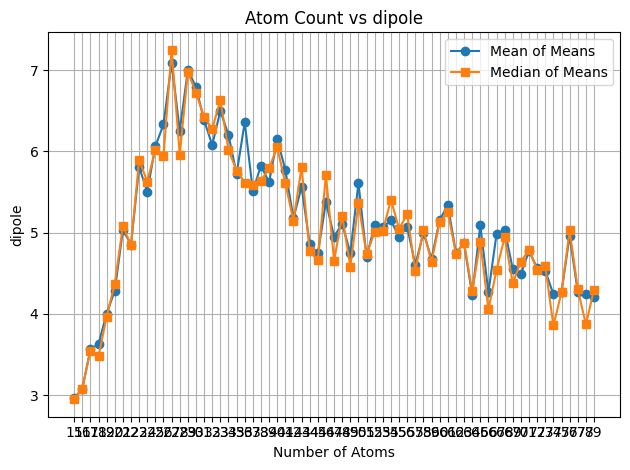

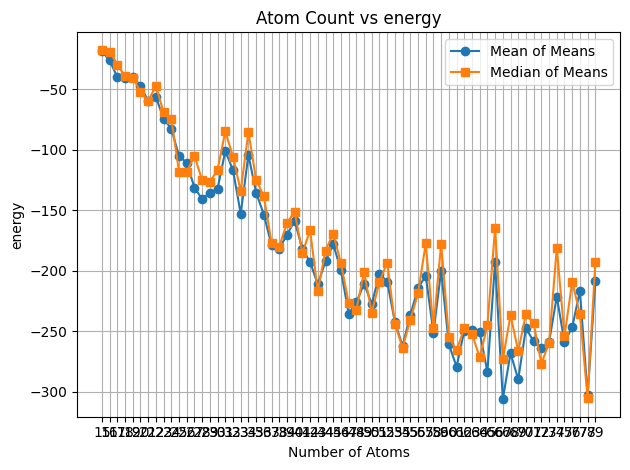

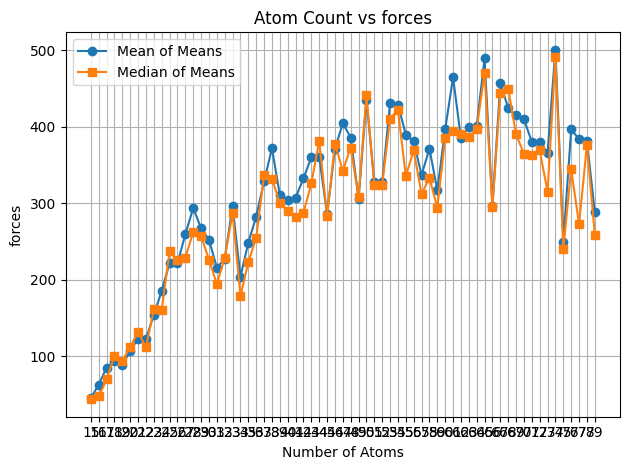

In [8]:
# MAIN EXECUTION
txt_file = '/Users/svlg/MasterThesis/v02/aa_experiments/sampling/geom/properties_geom_dxtb.txt'
df = parse_sampling_log(txt_file)
df.to_csv('/Users/svlg/MasterThesis/v02/aa_experiments/sampling/geom/sampling_summary.csv', index=False)
plot_stats(df, dataset='geom', save=True)